In [1]:
import numpy as np
from scipy.linalg import solve_continuous_are

In [2]:
M = 20  # kg
g = 9.8 # m / s^2
m = 0.5 # kg
l = 0.5 # m

In [3]:
v1 = ((M + m) * g) / (M * l)
v2 = -(m * g) / M

c1 = -1 / (M * l)
c2 = 1 / M

In [4]:
A = np.array([[0, 1, 0, 0], [0, 0, v2, 0], [0, 0, 0, 1], [0, 0, v1, 0]])
B = np.array([[0], [c2], [0], [c1]])

In [5]:
print(A)
print(B)

[[ 0.     1.     0.     0.   ]
 [ 0.     0.    -0.245  0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.     0.    20.09   0.   ]]
[[ 0.  ]
 [ 0.05]
 [ 0.  ]
 [-0.1 ]]


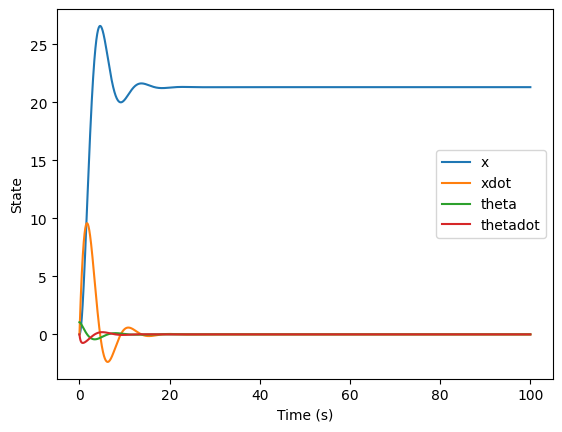

In [50]:
# Define the desired final value for theta
theta_f = np.pi/2

# Define the initial value for theta
theta_0 = np.pi/3

# Define the state vector x and the control input u
x = np.array([[0], [0], [theta_0], [0]])
u = 0

# Define the cost function weights Q and R
Q = np.diag([100, 100, 1, 1])   # higher weight on theta for control input stability
R = np.array([[0.1]])

# Compute the optimal gain matrix K using the ARE
P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)

# Simulate the system with the computed gain matrix K
t0, tf = 0, 100    # initial and final simulation time
dt = 0.01     # time step
t = np.arange(t0, tf, dt)
x_history = np.zeros((4, len(t)))
x_history[:, 0] = x[:, 0]

for i in range(1, len(t)):
    # Compute the control input using the optimal gain matrix K
    u = -K @ x

    # Update the state using the system dynamics
    x_dot = A @ x + B @ u
    x = x + x_dot * dt

    # Save the state history
    x_history[:, i] = x[:, 0]

# Plot the state history
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t, x_history[0, :], label='x')
plt.plot(t, x_history[1, :], label='xdot')
plt.plot(t, x_history[2, :], label='theta')
plt.plot(t, x_history[3, :], label='thetadot')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.show()

In [54]:
import cv2

class InvertedPendulum:
    def __init__(self):
        f = 0

    def step( self, state_vec, t=None ):
        """ state vector :
                x0 : position of the cart
                x1 : veclocity of the cart
                x2 : angle of pendulum. In ref frame with x as forward of the cart and y as up. Angile with respect to ground plane
                x3 : angular velocity of the pendulum
        """
        CART_POS = state_vec[0]
        BOB_ANG  = state_vec[2]*180. / np.pi # degrees
        LENGTH_OF_PENDULUM = 110.

        IM = np.zeros( (512, 512,3), dtype='uint8' )

        # Ground line
        cv2.line(IM, (0, 450), (IM.shape[1], 450), (19,69,139), 4 )


        # Mark ground line
        XSTART = -5.
        XEND = 50.
        for xd in np.linspace( XSTART, XEND, 11 ):
            x = int(   (xd - XSTART) / (XEND - XSTART) * IM.shape[0]   )

            cv2.circle( IM, (x, 450), 5, (0,255,0), -1 )

            cv2.putText(IM, str(xd), (x-15,450+15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1);


        # Draw Wheels of the cart
        wheel_1_pos = int(   (CART_POS - 1.2 - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        wheel_2_pos = int(   (CART_POS + 1.2 - XSTART) / (XEND - XSTART) * IM.shape[0]   )

        cv2.circle( IM, (wheel_1_pos, 415), 25, (255,255,255), 6 )
        cv2.circle( IM, (wheel_2_pos, 415), 25, (255,255,255), 6 )
        cv2.circle( IM, (wheel_1_pos, 415), 2, (255,255,255), -1 )
        cv2.circle( IM, (wheel_2_pos, 415), 2, (255,255,255), -1 )

        # Cart base
        cart_base_start = int(   (CART_POS - 2.5 - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        cart_base_end   = int(   (CART_POS + 2.5 - XSTART) / (XEND - XSTART) * IM.shape[0]   )

        cv2.line( IM, (cart_base_start, 380), (cart_base_end, 380), (255,255,255), 6 )

        # Pendulum hinge
        pendulum_hinge_x = int(   (CART_POS - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        pendulum_hinge_y = 380
        cv2.circle( IM, (pendulum_hinge_x, pendulum_hinge_y), 10, (255,255,255), -1 )


        # Pendulum
        pendulum_bob_x = int( LENGTH_OF_PENDULUM * np.cos( BOB_ANG / 180. * np.pi ) )
        pendulum_bob_y = int( LENGTH_OF_PENDULUM * np.sin( BOB_ANG / 180. * np.pi ) )
        cv2.circle( IM, (pendulum_hinge_x+pendulum_bob_x, pendulum_hinge_y-pendulum_bob_y), 10, (255,255,255), -1 )
        cv2.line( IM, (pendulum_hinge_x, pendulum_hinge_y), (pendulum_hinge_x+pendulum_bob_x, pendulum_hinge_y-pendulum_bob_y), (255,255,255), 3 )

        # Mark the current angle
        angle_display = BOB_ANG % 360
        if( angle_display > 180 ):
            angle_display = -360+angle_display
        cv2.putText(IM, "theta="+str( np.round(angle_display,4) )+" deg", (pendulum_hinge_x-15, pendulum_hinge_y-15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1)


        # Display on top
        if t is not None:
            cv2.putText(IM, "t="+str(np.round(t,4))+"sec", (15, 15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1)
            cv2.putText(IM, "ANG="+str(np.round(BOB_ANG,4))+" degrees", (15, 35), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1)
            cv2.putText(IM, "POS="+str(np.round(CART_POS,4))+" m", (15, 55), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1)



        return IM

In [55]:
print(x_history)

[[ 0.00000000e+00  0.00000000e+00  1.19949754e-03 ...  2.13020036e+01
   2.13020036e+01  2.13020036e+01]
 [ 0.00000000e+00  1.19949754e-01  2.39148750e-01 ... -5.42175724e-13
  -5.34485144e-13 -5.26811274e-13]
 [ 1.04719755e+00  1.04719755e+00  1.04685106e+00 ...  7.67628378e-14
   7.66072896e-14  7.64483849e-14]
 [ 0.00000000e+00 -3.46487886e-02 -6.77960596e-02 ... -1.55548231e-14
  -1.58904667e-14 -1.62231790e-14]]


In [56]:
syst = InvertedPendulum()
X = x_history

for i in range(len(X[0])):
    rendered = syst.step( [X[0][i], X[1][i], X[2][i], X[3][i]], t=i*0.001)
    print(X[2][i])
    cv2.imshow( 'im', rendered )

    # Press q to exit

    if cv2.waitKey(5) == ord('q'):
        break

1.0471975511965976
1.0471975511965976
1.0468510633106487
1.0461731027148713
1.045178034366691
1.0438796020301226
1.0422909559998914
1.0404246795827017
1.0382928143913541
1.035906884504916
1.0332779195457618
1.0304164767220299
1.0273326618818603
1.0240361496237058
1.020536202505018
1.0168416893897227
1.0129611029730798
1.0089025765207984
1.0046738998576248
1.0002825346390416
0.995735628938211
0.9910400311788528
0.9862023034433751
0.9812287341842614
0.9761253503654598
0.9708979290593271
0.9655520085235312
0.960092898781222
0.9545256917267406
0.9488552707781328
0.9430863200967838
0.9372233333935808
0.9312706223401375
0.9252323246027874
0.9191124115162577
0.9129146954131768
0.9066428366248479
0.9003003501680248
0.8938906121317712
0.8874168657778491
0.880882227367481
0.8742896917267577
0.8676421375624084
0.8609423325391287
0.8541929381291599
0.847396514244332
0.8405555236603274
0.8336723362424819
0.8267492329820281
0.8197884098512783
0.812791981485873
0.8057619847018483
0.7987003818549355
0

KeyboardInterrupt: 

: 